In [2]:
import os
import sys
import time
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp
from scipy.spatial import distance_matrix
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation

import pickle

%matplotlib inline

import re
numeric_const_pattern = r"""
     [-+]? 
     (?:
         (?: \d* \. \d+ )
         |
         (?: \d+ \.? )
     )
     (?: [Ee] [+-]? \d+ ) ?
     """
rx = re.compile(numeric_const_pattern, re.VERBOSE)

from IPython.display import clear_output
from IPython.display import Video

from scipy.stats.stats import pearsonr


/tmp/ipykernel_3967689/3749613158.py:36: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [7]:
outdir="./output/"
csvfiles = os.listdir(outdir)
df = pd.DataFrame([])
agents = ["DQN"]
games = ["CartPole-v1"]
lrs = ["2.5e-04"]
# optimizers = ["AdamPlus"]
optimizers = ["AdamSNR", "Adam+"]
# optimizers = ["AdaShift", "RMSprop", "PIDAOSI"]
# optimizers = ["Adam51"]
# lrs = ["1.0e-04"]
# seeds = [str(s) for s in range(20,26)]
# seeds = [str(s) for s in range(20,30)]
seeds = ["50"]
db_noises = ['-60.0', '-80.0', '-140.0']

# betas = ["0.9", "0.5", "0.999"]
betas = ["0.999"]
# explores = ["0.1", "0.11", '0.12', '0.15', '0.2', '0.5']
explores = ["0.1"]
end_es = ["0.05"]
dbs = ["0.0", "-10.0", "-15.0"]
# dbs = ["0.0"]
for csvfile in sorted(csvfiles):
    if ".csv" not in csvfile:
        continue
    cfgs = csvfile[0:-4].split("_")
    # print(csvfile[0:-4])
    env, agent, optimizer, learning_rate, beta2, seed = cfgs[0], cfgs[1], cfgs[2], cfgs[3], cfgs[4], cfgs[5]
    if len(cfgs) <= 10:
        continue
    explore_frac, db = cfgs[7], cfgs[9]
    explore_end = cfgs[11]
    db_noise = ""
    if len(cfgs) >= 13:
        db_noise = cfgs[12]
    if db_noise not in db_noises:
        continue
    if optimizer not in optimizers:
        continue
    if env not in games:
        continue
    if explore_frac not in explores:
        continue
    if explore_end not in end_es:
        continue
    if agent not in agents:
        continue
    if learning_rate not in lrs:
        continue
    if db not in dbs:
        continue
    if beta2 not in betas:
        continue
    if seed[4:] not in seeds:
        continue
    try:
        # df_tmp = pd.read_csv(os.path.join(outdir, csvfile), index_col=0)
        df_tmp = pd.read_csv(os.path.join(outdir, csvfile), index_col=None)
    except:
        continue
    df_tmp["env"] = cfgs[0]
    df_tmp["agent"] = cfgs[1]
    # df_tmp["db"] = float(db)
    df_tmp["db"] = db
    df_tmp["db_noise"] = db_noise
    # if optimizer =="Adam+" and db =="-20.0":
    #     df_tmp["optimizer"] = optimizer + "(FL -80.0)"        
    # elif optimizer == "AdamPlus" and db =="-20.0":
    #     df_tmp["optimizer"] = optimizer + "(th -20.0)"                
    # else:
    #     df_tmp["optimizer"] = optimizer
    df_tmp["optimizer"] = optimizer
    df_tmp["learning_rate"]=cfgs[3]
    df_tmp["beta2"]=cfgs[4]
    df_tmp["seed"]= seed[4:]
    df_tmp["lr"] = df_tmp["lr"] #.str.strip("[]").astype(float)
    df_tmp["exploration_fraction"] = explore_frac
    df_tmp["time"] = df_tmp["runtime"].cumsum(axis=0)
    df = pd.concat([df, df_tmp], ignore_index=False)
    print(csvfile[0:-4])

# df = df.reset_index()
# epsilon = 1e-8
# df["m_sr_v"] = df["m"] / (np.sqrt(df["v"]) + epsilon)
# df["AdamPlusSNR"] = df["AdamPlusSNR"].replace([np.inf, -np.inf], 0)
# df["SNR"] = df["SNR"].fillna(0)
# df["EmaSNR"] = df["EmaSNR"].fillna(0)
# df = pd.concat([df, df_saved], ignore_index=False)
df = df.reset_index(drop=True)
df

CartPole-v1_DQN_Adam+_2.5e-04_0.999_seed50_128_0.1_10_0.0_0.99_0.05_-60.0
CartPole-v1_DQN_AdamSNR_2.5e-04_0.999_seed50_128_0.1_10_0.0_0.99_0.05_-60.0


,global_step,episode,return,SNR,EmaSNR,AdamPlusSNR,m,v,g,pwr_noise,...,env,agent,db,db_noise,optimizer,learning_rate,beta2,seed,exploration_fraction,time
0,9,0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,CartPole-v1,DQN,0.0,-60.0,Adam+,2.5e-04,0.999,50,0.1,0.001368
1,29,1,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,CartPole-v1,DQN,0.0,-60.0,Adam+,2.5e-04,0.999,50,0.1,0.009084
2,51,2,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,CartPole-v1,DQN,0.0,-60.0,Adam+,2.5e-04,0.999,50,0.1,0.020989
3,68,3,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,CartPole-v1,DQN,0.0,-60.0,Adam+,2.5e-04,0.999,50,0.1,0.036251
4,97,4,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,CartPole-v1,DQN,0.0,-60.0,Adam+,2.5e-04,0.999,50,0.1,0.055685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4450,497674,2144,500.0,NaN,-14.674054,NaN,NaN,-15.079190,NaN,NaN,...,CartPole-v1,DQN,0.0,-60.0,AdamSNR,2.5e-04,0.999,50,0.1,279158.272406
4451,498174,2145,500.0,NaN,-22.211105,NaN,NaN,-15.229458,NaN,NaN,...,CartPole-v1,DQN,0.0,-60.0,AdamSNR,2.5e-04,0.999,50,0.1,279642.840463
4452,498674,2146,500.0,NaN,-26.645763,NaN,NaN,-14.439814,NaN,NaN,...,CartPole-v1,DQN,0.0,-60.0,AdamSNR,2.5e-04,0.999,50,0.1,280127.913992
4453,499174,2147,500.0,NaN,-16.195345,NaN,NaN,-14.371191,NaN,NaN,...,CartPole-v1,DQN,0.0,-60.0,AdamSNR,2.5e-04,0.999,50,0.1,280613.502079


In [8]:
# Step 1: Average over seeds for each (optimizer, beta2, chunk)
# df_agg = df.groupby(["optimizer", "beta2", "chunk"])["return"].mean().reset_index()
chunk_size = 1000
# Step 1: Add a chunk index column
df = df.copy()
df["chunk"] = (df["global_step"] // chunk_size + 1) * chunk_size

# Step 2: Compute average return within each chunk per config and seed
agg_df = df.groupby(["optimizer", "beta2", "seed", "db", "db_noise", "chunk"])[["return", "EmaSNR", "v"]].mean().reset_index()
# agg_df = df.groupby(["optimizer", "beta2", "chunk"])["return"].mean().reset_index()
df_s3 = df.groupby(["optimizer", "beta2", "seed", "db", "db_noise", "chunk"])["lr"].min().reset_index()
agg_df = pd.concat([agg_df, df_s3["lr"]], axis=1)

# Optional: For plotting, rename for clarity
agg_df.rename(columns={"chunk": "global_step", "return": "return"}, inplace=True)

In [11]:
agg_df

,optimizer,beta2,seed,db,db_noise,global_step,return,SNR,v,lr
0,Adam+,0.999,50,0.0,-60.0,1000,22.066667,NaN,NaN,0.00025
1,Adam+,0.999,50,0.0,-60.0,2000,22.790698,NaN,NaN,0.00025
2,Adam+,0.999,50,0.0,-60.0,3000,23.418605,NaN,NaN,0.00025
3,Adam+,0.999,50,0.0,-60.0,4000,25.300000,NaN,NaN,0.00025
4,Adam+,0.999,50,0.0,-60.0,5000,22.377778,NaN,NaN,0.00025
...,...,...,...,...,...,...,...,...,...,...
995,AdamSNR,0.999,50,0.0,-60.0,496000,339.666667,-13.629069,-22.303225,0.00025
996,AdamSNR,0.999,50,0.0,-60.0,497000,500.000000,-19.664644,-18.364313,0.00025
997,AdamSNR,0.999,50,0.0,-60.0,498000,500.000000,-14.921148,-15.311183,0.00025
998,AdamSNR,0.999,50,0.0,-60.0,499000,500.000000,-24.428434,-14.834636,0.00025


In [15]:
agg_df['global_step'] = agg_df['global_step']/1000

./output/fig/AdamPlus_CartPole-v1_exp2-fixed-5k_2.5e-04_0.0_0.05_return.pdf
./output/fig/AdamPlus_CartPole-v1_exp2-fixed-5k_2.5e-04_0.0_0.05_SNR.pdf


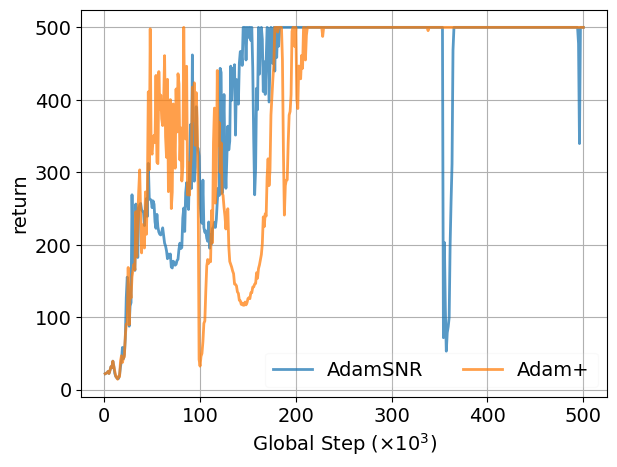

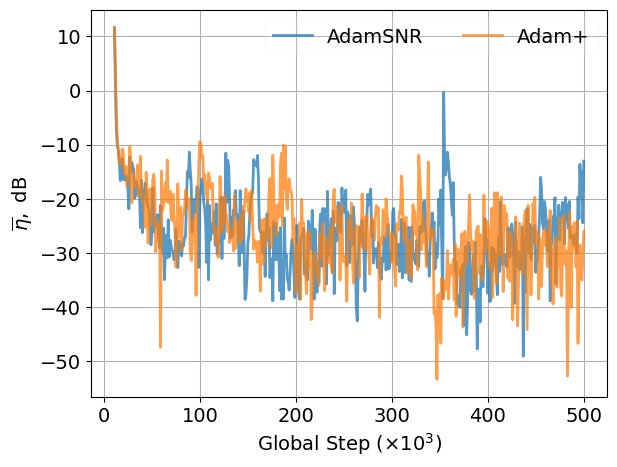

In [17]:
agg_df = agg_df.rename(columns={"EmaSNR": "SNR"})
items = ["return", "SNR"]
# items = ["return"]
# hue_order = ["Adam","AdamPlus","Adam+", "Adam2","Adam5", "Lion", "AMSGrad", "AdaBeliefW", "Adopt", "AdaBelief"]
# hue_order = ["Adam","AMSGrad", "Adam+", "Adam+ (SNR lr)", "Adopt", ]
# hue_order = ["Adam","Adam+"]
# hue_order = ["Adam51"]
seedstr = 'exp2-fixed-5k'
end_e = '0.05'

df_tmp = agg_df
# df_tmp['optimizer'] = df_tmp['optimizer'].replace("AdamSNR", "Adam")
# df_tmp= df_tmp[df_tmp["beta2"]=="0.999"]
# df_tmp= df_tmp[df_tmp["optimizer"]=="AdamPlus"]
# df_tmp= df_tmp[df_tmp["exploration_fraction"]=="0.1"]
# for item in ["avg_return", "lr"]: 
for item in items: 
    fname = './output/fig/AdamPlus_{}_{}_{}_{}_{}_{}.pdf'.format(games[0], seedstr, lrs[0], dbs[0], end_e, item)
    # fname = '../../fig/AdamPlus_{}_seeds_32-36_{}.pdf'.format(games[0], item)
    fig, ax = plt.subplots(1, 1, sharey=False, figsize=(6, 4.5))
    # fig, ax = plt.subplots(1, 1, sharey=False, figsize=(10, 4.5))
    
    sns.lineplot(
        data=df_tmp, 
        # x="episode", 
        x="global_step", 
        y=item, 
        hue="optimizer",
        # hue_order=["Adam","AdamPlus", "AMSGrad","Adam5",],
        hue_order=optimizers,
        # style="db_noise",
        # style_order=["-140.0", "-80.0"],
        # style="beta2",
        # style_order=["0.999", "0.9","0.5","0.99",],
        palette="tab10", 
        errorbar=None,
        # markers=["o", "p", "*"],
        # markersize=14,
        # dashes=False,
        # linestyle="dotted",
        linewidth=2,
        alpha=0.75,
        ax=ax,
    )
    
    L = ax.legend(
        fontsize=14,
        framealpha=0.1,
        ncol=2,
        # loc='upper right',
        # loc='lower right',
    )
    # if item in ["lr"]:
    #     plt.yscale("log")
    # ax.set_ylim([-5, 510])
    # ax.get_legend().remove()
    # ax.set_ylim([-1000, 1])
    # ax.set_xlim([-10, 510])
    ax.grid(True)
    ax.set_xlabel(r'Global Step ($\times 10^3$)', fontsize=14)
    ax.set_ylabel(item, fontsize=14)
    if item in ['v']:
        ax.set_ylabel(r"$\overline{v}, \text{dB}$", fontsize=14)
    if item in ['SNR']:
        ax.set_ylabel(r"$\overline{\eta},\ \text{dB}$", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    
    print(fname)
    # fig.set_size_inches(5.5, 4.5)
    plt.tight_layout(pad=0.1)
    fig.savefig(fname,
                dpi=300,  # facecolor='w', edgecolor='w',
                orientation='portrait',
                format='pdf')


In [10]:
df_agg = agg_df.groupby(["optimizer", "beta2", "db", "db_noise", "global_step"])["return"].mean().reset_index()

# Step 2: AUC via trapezoidal rule per config
auc_df = df_agg.groupby(["optimizer", "beta2", "db", "db_noise"]).apply(
    lambda g: np.trapz(y=g["return"], x=g["global_step"])
).reset_index(name="auc")

auc_df['auc_norm'] = auc_df['auc']/(500 * 500000)

# Step 3: Fraction of time at max return (500), using isclose for float tolerance
frac_df = df_agg.groupby(["optimizer", "beta2", "db", "db_noise"]).apply(
    lambda g: np.isclose(g["return"], 500, atol=1e-3).sum() / len(g)
).reset_index(name="frac_at_500")

df_cartpole=pd.concat([auc_df, frac_df['frac_at_500']], axis=1)
df_cartpole.sort_values(by='auc_norm', ascending=False)

,optimizer,beta2,db,db_noise,auc,auc_norm,frac_at_500
4,AdamPlus,0.999,-15.0,-60.0,2.133142e+08,0.853257,0.306
1,AdamPlus,0.999,-10.0,-60.0,2.130673e+08,0.852269,0.254
6,AdamPlus,0.999,0.0,-140.0,2.070334e+08,0.828133,0.226
5,AdamPlus,0.999,-15.0,-80.0,2.056362e+08,0.822545,0.256
3,AdamPlus,0.999,-15.0,-140.0,2.042474e+08,0.816990,0.084
2,AdamPlus,0.999,-10.0,-80.0,2.036931e+08,0.814772,0.178
0,AdamPlus,0.999,-10.0,-140.0,1.997389e+08,0.798956,0.084


In [6]:
env_name = 'cartpole'

file_dict_adam = {f'K50_seed{seed}': f'output/{env_name}_seed{seed}_DDQN_Adam.txt' for seed in range(42, 52)}
file_dict_adam_plus = {f'K50_seed{seed}': f'output/{env_name}_seed{seed}_DDQN_AdamPlus.txt' for seed in range(42, 52)}

In [23]:
outs_adam, min_len = read_files(file_dict_adam)
data_adam = read_metrics(outs_adam, min_len)

outs_adam_plus, min_len = read_files(file_dict_adam_plus)
data_adam_plus = read_metrics(outs_adam_plus, min_len)

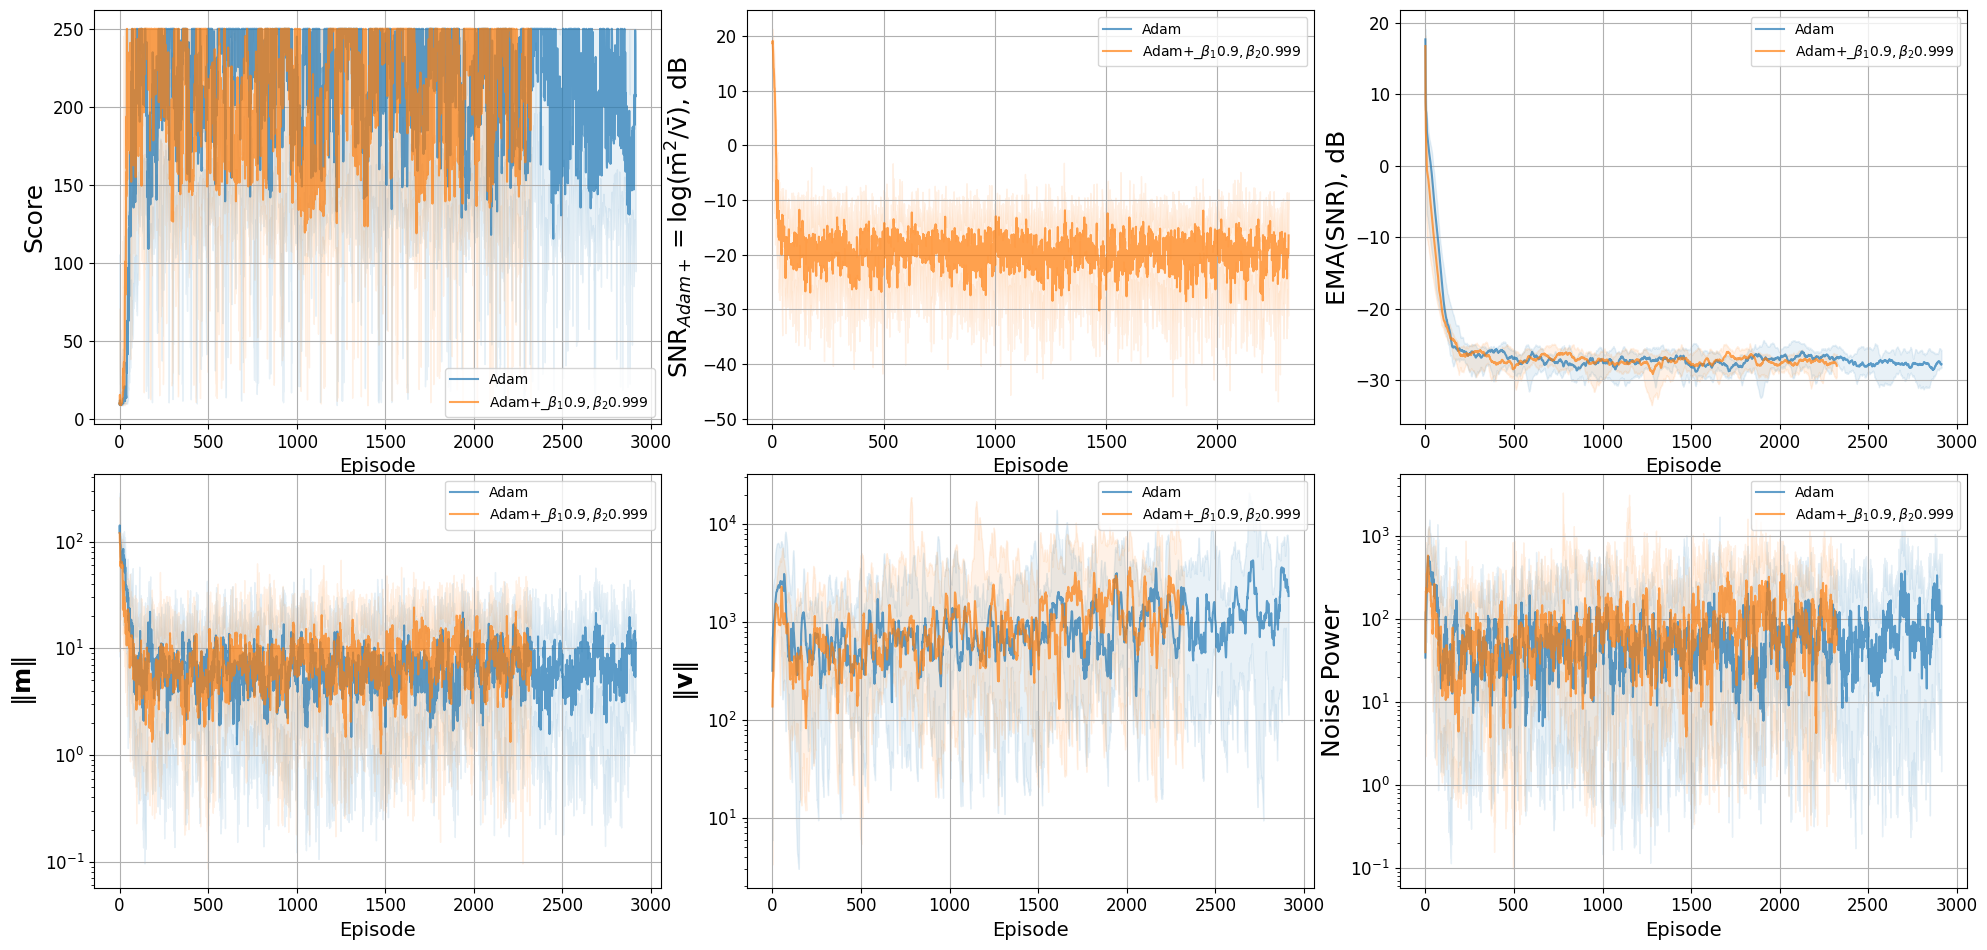

In [24]:
scale = 2
fig, axes = plt.subplots(2, 3, figsize=(scale*10, scale*4.8))
axes = axes if isinstance(axes, np.ndarray) else np.array([axes])
axes = axes.flatten()
# plt.setp(axes, xlim=[0, 10000])
axes = plot_metrics(axes, data_adam, label='Adam')
axes = plot_metrics(axes, data_adam_plus, label=r'Adam+_$\beta_10.9, \beta_20.999$')
plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.12)
# plt.savefig(f'output/fig/{env_name}.png')
plt.show()

In [29]:
def cifar_log_to_csv(log_text):
    
    pattern = r"\[(\d+),\s+(\d+)\] loss_tr: ([\d.]+) loss_te: ([\d.]+) acc_tr: ([\d.]+) acc_te: ([\d.]+)"
    data = re.findall(pattern, log_text)
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["epoch", "samples", "loss_tr", "loss_te", "acc_tr", "acc_te"])
    df = df.astype({
        "epoch": int,
        "samples": int,
        "loss_tr": float,
        "loss_te": float,
        "acc_tr": float,
        "acc_te": float
    })
    return df

In [2809]:
df

,global_step,episode,return,SNR,EmaSNR,AdamPlusSNR,m,v,g,pwr_noise,...,lr,env,agent,optimizer,q_lr,beta2,seed,noise_injection,policy_lr,time
0,999,0,-364.191809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0003,HalfCheetah-v5,SAC,Adam+,0.0003,0.999,1,-60.0,0.0003,1.341599e+00
1,999,0,-224.887657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0003,HalfCheetah-v5,SAC,Adam+,0.0003,0.999,1,-60.0,0.0003,2.696140e+00
2,999,0,-234.554035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0003,HalfCheetah-v5,SAC,Adam+,0.0003,0.999,1,-60.0,0.0003,4.054543e+00
3,999,0,-360.873876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0003,HalfCheetah-v5,SAC,Adam+,0.0003,0.999,1,-60.0,0.0003,5.417203e+00
4,2000,1,-425.154205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0003,HalfCheetah-v5,SAC,Adam+,0.0003,0.999,1,-60.0,0.0003,8.171845e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7271,538536,537,11036.506165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0003,HalfCheetah-v5,SAC,Adam,0.0003,0.999,1,0.0,0.0003,1.830070e+07
7272,539537,538,11009.773401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0003,HalfCheetah-v5,SAC,Adam,0.0003,0.999,1,0.0,0.0003,1.831817e+07
7273,539537,538,10917.084873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0003,HalfCheetah-v5,SAC,Adam,0.0003,0.999,1,0.0,0.0003,1.833564e+07
7274,539537,538,10622.820922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0003,HalfCheetah-v5,SAC,Adam,0.0003,0.999,1,0.0,0.0003,1.835311e+07


In [3439]:
# df

In [1913]:
outdir="./output/"
csvfiles = os.listdir(outdir)
df = pd.DataFrame([])
agents = ["SAC"]
games = ["Hopper-v5"]
lrs = ["3.0e-04"]
# lrs = ["1.0e-04"]
# seeds = ["30", "31", "32", "33", "34", "35", "36", "37"]
# seeds = ["31", "32", "33", "34", "35", "36", "37"]
# seeds = [str(s) for s in range(20,26)]
# seeds = [str(s) for s in range(30,36)]
seeds = [str(s) for s in range(1,11)]
# seeds = [str(s) for s in range(1,10)]

# seeds = ["34", "35", "36"]
# seeds = ["30"]
# betas = ["0.9", "0.5", "0.999"]
betas = ["0.999"]
explores = ["0.1"]
end_es = ["0.2"]
dbs = ["0.0"]
# betas = ["0.999"]
# game="lander"
# game="pong"
# game="breakout"
# game="spaceinvaders"
for csvfile in csvfiles:
    if ".csv" not in csvfile:
        continue
    cfgs = csvfile[0:-4].split("_")
    env, agent, optimizer, learning_rate, beta2, seed = cfgs[0], cfgs[1], cfgs[2], cfgs[3], cfgs[4], cfgs[5] 
    num_envs,policy_lr, db = cfgs[8],cfgs[7], cfgs[9]
    batch = cfgs[6]
    tau = cfgs[-1]
    if batch not in ["256"]:
        continue
    if env not in games:
        continue
    # print(csvfile[0:-4])
    if tau not in end_es:
        continue
    if agent not in agents:
        continue
#     if policy_lr not in ["0.001"]:
    if policy_lr not in ["0.0003"]:
        continue
    if learning_rate not in lrs:
        continue
    if num_envs not in ["1"]:
        continue
    if beta2 not in betas:
        continue
    if seed[4:] not in seeds:
        continue
    try:
        df_tmp = pd.read_csv(os.path.join(outdir, csvfile), index_col=None)
    except:
        continue
    df_tmp["env"] = cfgs[0]
    df_tmp["agent"] = cfgs[1]
    if optimizer=="Adam+" and db!="-120.0":
        df_tmp["optimizer"] = "Adam+ (FL {})".format(db)
    elif optimizer=="AdamPlus" and db!="-120.0":
        df_tmp["optimizer"] = "AdamPlus (th {})".format(db)
    else:
        df_tmp["optimizer"] = cfgs[2]
    df_tmp["q_lr"]=df_tmp["lr"]  
    df_tmp["beta2"]=beta2
    df_tmp["seed"]= seed[4:]
    df_tmp["noise_injection"] = float(db)
    df_tmp["policy_lr"] = policy_lr #.str.strip("[]").astype(float)
    df_tmp["return"] = df_tmp["return"] #.str.strip("[]").astype(float)
    df_tmp["time"] = df_tmp["runtime"].cumsum(axis=0)
    df = pd.concat([df, df_tmp], ignore_index=False)
    print(csvfile[0:-4])

# df = pd.concat([df, df_saved], ignore_index=False)
df = df.reset_index(drop=True)
# df.loc[df["opt"]=="Adam", "lr"]=0.0001
# df

Hopper-v5_SAC_AdamPlus_3.0e-04_0.999_seed1_256_0.0003_1_-15.0_0.99_0.2
Hopper-v5_SAC_AdamPlus_3.0e-04_0.999_seed1_256_0.0003_1_-6.0_0.99_0.2
Hopper-v5_SAC_Adam51_3.0e-04_0.999_seed1_256_0.0003_1_-60.0_0.99_0.2
Hopper-v5_SAC_Adam+_3.0e-04_0.999_seed1_256_0.0003_1_-60.0_0.99_0.2
Hopper-v5_SAC_AdamPlus_3.0e-04_0.999_seed1_256_0.0003_1_-10.0_0.99_0.2
Hopper-v5_SAC_Adam52_3.0e-04_0.999_seed1_256_0.0003_1_-60.0_0.99_0.2
Hopper-v5_SAC_Adam+_3.0e-04_0.999_seed1_256_0.0003_1_-80.0_0.99_0.2
Hopper-v5_SAC_Adam_3.0e-04_0.999_seed1_256_0.0003_1_-60.0_0.99_0.2
Hopper-v5_SAC_Adam+_3.0e-04_0.999_seed1_256_0.0003_1_-120.0_0.99_0.2
Hopper-v5_SAC_AdamPlus_3.0e-04_0.999_seed1_256_0.0003_1_-80.0_0.99_0.2
Hopper-v5_SAC_Adam0_3.0e-04_0.999_seed1_256_0.0003_1_0.0_0.99_0.2


../../fig/AdamPlus_Hopper-v5_default-gpu-1M-s1_3_0e-04_0_0_0_05_return.pdf


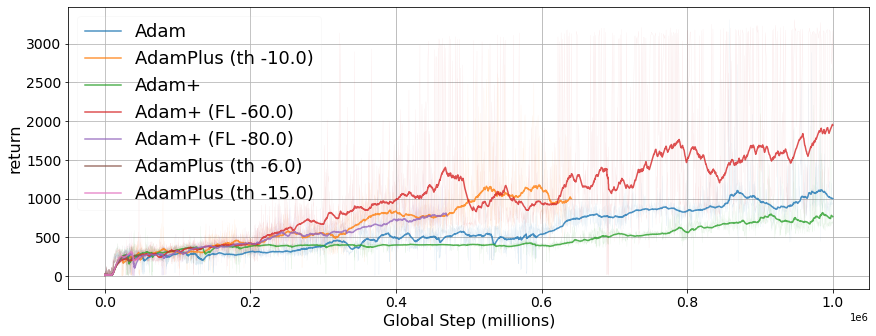

In [1914]:
# hue_order = ["Adam","AdamPlus","Adam+", "Adam2","Adam5", "Lion", "AMSGrad", "AdaBeliefW", "Adopt", "AdaBelief"]
hue_order = [
    "Adam",
    "AdamPlus (th -10.0)",
    "Adam+",
    "Adam+ (FL -60.0)",
    "Adam+ (FL -80.0)" ,
    "AdamPlus (th -6.0)",
    "AdamPlus (th -15.0)",
    #  "Adam52",
] 
seedstr = 'default-gpu-1M-s1'
# seedstr = 'env2-default-100k'
# seedstr = 'env1-cleanrl-100k'
fontsize=16

df_tmp = df
# df_tmp= df_tmp[df_tmp["global_step"]<=200000]
# df_tmp = agg_df
# df_tmp= df_tmp[df_tmp["beta2"]=="0.999"]
# df_tmp= df_tmp[df_tmp["seed"]==seedstr]
# df_tmp= df[df["env"]=="lander"]
# for item in ["avg_return", "lr"]: 
for item in ["return"]: 
    fname = '../../fig/AdamPlus_{}_{}_{}_{}_{}_{}.pdf'.format(games[0], seedstr, lrs[0], dbs[0], tau, item)
    # fname = '../../fig/AdamPlus_{}_seeds_32-36_{}.pdf'.format(games[0], item)
    fig, ax = plt.subplots(1, 1, sharey=False, figsize=(12, 4.5))
    
    # Add EMA (exponential moving average) of `item` column to df_tmp
    alpha = 0.02  # smoothing factor, tune this to adjust the amount of smoothing
    ema_col = f"{item}_ema"
    
    df_tmp[ema_col] = (
        df_tmp
        .groupby(["optimizer"])[item]
        .transform(lambda x: x.ewm(alpha=alpha).mean())
    )
    
    sns.lineplot(
        data=df_tmp, 
        x="global_step", 
        # x="time", 
        y=item, 
        hue="optimizer",
        hue_order=hue_order,
#         style="db",
#         style_order=[-120, -60.0,0],
        # style="beta2",
        # style_order=["0.999","0.5","0.9","0.901", "0.902", "0.903"],
        # style_order=["0.999", ], # "0.501", 
        palette="tab10", 
        errorbar=None,
    #     markers=["o", "p", "*"],
        # markersize=14,
    #     dashes=False,
    #     linestyle="dotted",
        ax=ax,
        linewidth=0.2,
        alpha=0.15,
        legend=False,  # avoid duplicate legend entries
    )
    
    # 2. Smoothed EMA curve (thicker and more prominent)
    sns.lineplot(
        data=df_tmp,
        x="global_step",
#         y=item, 
        y=ema_col,
        hue="optimizer",
        hue_order=hue_order,
#         style="noise_injection",
#         style_order=[-120, -60.0, 0],
        # style="beta2",
        # style_order=["0.999"],
        palette="tab10",
        errorbar=None,
        ax=ax,
        linewidth=1.5,
        alpha=0.8,
        # legend=False,  # avoid duplicate legend entries
    )    
    
    
    L = ax.legend(
        fontsize=18,
        framealpha=0.1,
        ncol=1,
        # loc='upper right',
    #     loc='lower right',
    )

#     if item in ["lr"]:
#         plt.yscale("log")
#     ax.set_ylim([-5, 510])
    # ax.get_legend().remove()
    # ax.set_ylim([-1000, 1])
#     ax.set_xlim([0, 2000])
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlabel('Global Step (millions)', fontsize=fontsize)
    ax.set_ylabel(item, fontsize=fontsize)
    
    fname = fname.replace('.0','_0')
    print(fname)
    # fig.set_size_inches(5.5, 4.5)
    plt.tight_layout(pad=0.1)
    fig.savefig(fname,
                dpi=300,  # facecolor='w', edgecolor='w',
                orientation='portrait',
                format='pdf')


In [1175]:
!date

Thu May 15 12:25:53 UTC 2025


In [1557]:
# df['optimizer'].unique()
df.groupby(['optimizer'])['global_step'].max()

optimizer
Adam                2999995
Adam+               2999995
Adam+ (FL -60.0)    1604601
Adam+ (FL -80.0)      18016
Adam+0              2999995
Adam52               554552
Name: global_step, dtype: int64

## HalfCheetah-v5

In [1915]:
outdir="./output/"
csvfiles = os.listdir(outdir)
df = pd.DataFrame([])
agents = ["SAC"]
games = ["HalfCheetah-v5"]
lrs = ["3.0e-04"]
# lrs = ["1.0e-04"]
# seeds = ["30", "31", "32", "33", "34", "35", "36", "37"]
# seeds = ["31", "32", "33", "34", "35", "36", "37"]
# seeds = [str(s) for s in range(20,26)]
seeds = [str(s) for s in range(1,10)]

# seeds = ["34", "35", "36"]
# seeds = ["30"]
# betas = ["0.9", "0.5", "0.999"]
betas = ["0.999"]
explores = ["0.1"]
end_es = ["0.2"]
dbs = ["0.0"]
# betas = ["0.999"]
# game="lander"
# game="pong"
# game="breakout"
# game="spaceinvaders"
for csvfile in csvfiles:
    if ".csv" not in csvfile:
        continue
    cfgs = csvfile[0:-4].split("_")
    env, agent, optimizer, learning_rate, beta2, seed = cfgs[0], cfgs[1], cfgs[2], cfgs[3], cfgs[4], cfgs[5] 
    num_envs,policy_lr, db = cfgs[8],cfgs[7], cfgs[9]
    batch = cfgs[6]
    tau = cfgs[-1]
    if batch not in ["256"]:
        continue
    if env not in games:
        continue
    # print(csvfile[0:-4])
    if tau not in end_es:
        continue
    if agent not in agents:
        continue
    if policy_lr not in ["0.0003"]:
        continue
    if learning_rate not in lrs:
        continue
    if num_envs not in ["1"]:
        continue
    if beta2 not in betas:
        continue
    if seed[4:] not in seeds:
        continue
    try:
        df_tmp = pd.read_csv(os.path.join(outdir, csvfile), index_col=None)
    except:
        continue
    df_tmp["env"] = cfgs[0]
    df_tmp["agent"] = cfgs[1]
#     if optimizer=="Adam+" and db!="-60.0":
#         df_tmp["optimizer"] = "Adam+ (no NI)"
    if optimizer=="Adam+" and db!="-120.0":
        df_tmp["optimizer"] = "Adam+ (FL {})".format(db)
    elif optimizer=="AdamPlus" and db!="-120.0":
        df_tmp["optimizer"] = "AdamPlus (th {})".format(db)
    else:
        df_tmp["optimizer"] = cfgs[2]
    df_tmp["q_lr"]=df_tmp["lr"]  
    df_tmp["beta2"]=beta2
    df_tmp["seed"]= seed[4:]
    df_tmp["noise_injection"] = float(db)
    df_tmp["policy_lr"] = policy_lr #.str.strip("[]").astype(float)
    df_tmp["return"] = df_tmp["return"] #.str.strip("[]").astype(float)
    df_tmp["time"] = df_tmp["runtime"].cumsum(axis=0)
    df = pd.concat([df, df_tmp], ignore_index=False)
    print(csvfile[0:-4])

# df = pd.concat([df, df_saved], ignore_index=False)
df = df.reset_index(drop=True)
# df

HalfCheetah-v5_SAC_Adam+0_3.0e-04_0.999_seed1_256_0.0003_1_-60.0_0.99_0.2
HalfCheetah-v5_SAC_AdamPlus_3.0e-04_0.999_seed1_256_0.0003_1_-6.0_0.99_0.2
HalfCheetah-v5_SAC_Adam_3.0e-04_0.999_seed1_256_0.0003_1_-120.0_0.99_0.2
HalfCheetah-v5_SAC_Adam+_3.0e-04_0.999_seed1_256_0.0003_1_-80.0_0.99_0.2
HalfCheetah-v5_SAC_Adam+_3.0e-04_0.999_seed1_256_0.0003_1_-60.0_0.99_0.2
HalfCheetah-v5_SAC_Adam52_3.0e-04_0.999_seed1_256_0.0003_1_-60.0_0.99_0.2
HalfCheetah-v5_SAC_AdamPlus_3.0e-04_0.999_seed1_256_0.0003_1_-15.0_0.99_0.2
HalfCheetah-v5_SAC_Adam+_3.0e-04_0.999_seed1_256_0.0003_1_-120.0_0.99_0.2
HalfCheetah-v5_SAC_AdamPlus_3.0e-04_0.999_seed1_256_0.0003_1_-10.0_0.99_0.2


../../fig/AdamPlus_HalfCheetah-v5_env1-official_3_0e-04_0_0_0_05_return.pdf


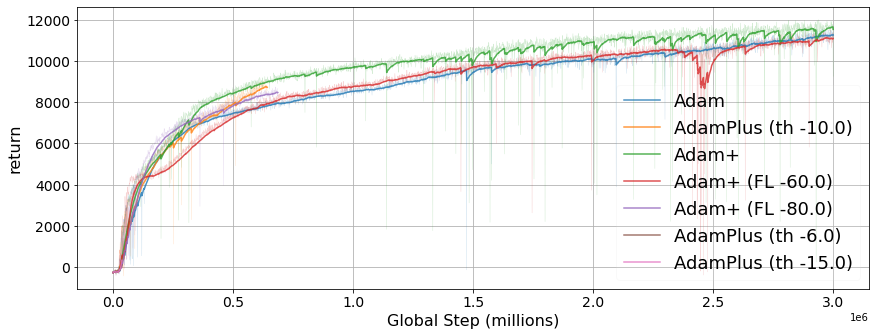

In [1916]:
# hue_order = ["Adam","AdamPlus","Adam+", "Adam2","Adam5", "Lion", "AMSGrad", "AdaBeliefW", "Adopt", "AdaBelief"]
# hue_order = ["Adam","Adam52", "Adam+ (no NI)","Adam+", "Adam+0"]
hue_order = [
    "Adam", 
    # "AdamPlus", "Adam+ (FL -60.0)",  "Adam+", "Adam+ (FL -80.0)", 
    "AdamPlus (th -10.0)",
    "Adam+",
    "Adam+ (FL -60.0)",
    "Adam+ (FL -80.0)" ,
    "AdamPlus (th -6.0)",
    "AdamPlus (th -15.0)",
]
seedstr = 'env1-official'

df_tmp = df
# df_tmp = agg_df
# df_tmp= df_tmp[df_tmp["global_step"]<=1000000]
# df_tmp= df_tmp[df_tmp["beta2"]=="0.999"]
# df_tmp= df_tmp[df_tmp["seed"]==seedstr]
# df_tmp= df[df["env"]=="lander"]
# for item in ["avg_return", "lr"]: 
for item in ["return"]: 
    fname = '../../fig/AdamPlus_{}_{}_{}_{}_{}_{}.pdf'.format(games[0], seedstr, lrs[0], dbs[0], tau, item)
    # fname = '../../fig/AdamPlus_{}_seeds_32-36_{}.pdf'.format(games[0], item)
    fig, ax = plt.subplots(1, 1, sharey=False, figsize=(12, 4.5))
    
    # Add EMA (exponential moving average) of `item` column to df_tmp
    alpha = 0.05  # smoothing factor, tune this to adjust the amount of smoothing
    ema_col = f"{item}_ema"
    
    df_tmp[ema_col] = (
        df_tmp
        .groupby(["optimizer", "beta2"])[item]
        .transform(lambda x: x.ewm(alpha=alpha).mean())
    )
    
    sns.lineplot(
        data=df_tmp, 
        x="global_step", 
        # x="time", 
        y=item, 
        hue="optimizer",
        hue_order=hue_order,
#         style="noise_injection",
#         style_order=[-120, -60.0],
        # style_order=["0.999", ], # "0.501", 
        palette="tab10", 
        errorbar=None,
    #     markers=["o", "p", "*"],
        # markersize=14,
    #     dashes=False,
    #     linestyle="dotted",
        ax=ax,
        linewidth=0.4,
        alpha=0.25,
        legend=False,  # avoid duplicate legend entries
    )
    
    # 2. Smoothed EMA curve (thicker and more prominent)
    sns.lineplot(
        data=df_tmp,
        x="global_step",
#         y=item, 
        y=ema_col,
        hue="optimizer",
        hue_order=hue_order,
#         style="noise_injection",
#         style_order=[-120, -60.0],
        palette="tab10",
        errorbar=None,
        ax=ax,
        linewidth=1.5,
        alpha=0.8,
        # legend=False,  # avoid duplicate legend entries
    )    
    
    
    L = ax.legend(
        fontsize=18,
        framealpha=0.1,
        ncol=1,
        # loc='upper right',
    #     loc='lower right',
    )

#     if item in ["lr"]:
#         plt.yscale("log")
#     ax.set_ylim([-5, 510])
    # ax.get_legend().remove()
    # ax.set_ylim([-1000, 1])
#     ax.set_xlim([0, 2000])
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlabel('Global Step (millions)', fontsize=fontsize)
    ax.set_ylabel(item, fontsize=fontsize)
    
    fname = fname.replace('.0','_0')
    print(fname)
    # fig.set_size_inches(5.5, 4.5)
    plt.tight_layout(pad=0.1)
    fig.savefig(fname,
                dpi=300,  # facecolor='w', edgecolor='w',
                orientation='portrait',
                format='pdf')


In [1918]:
chunk_size = 2500

# Step 1: Add a chunk index column
df = df.copy()
df["chunk"] = (df["global_step"] // chunk_size + 1) * chunk_size

# Step 2: Compute average return within each chunk per config and seed
agg_df = df.groupby(["optimizer", "beta2", "noise_injection", "chunk"])["return"].mean().reset_index()
# agg_df = df.groupby(["optimizer", "beta2", "chunk"])["return"].mean().reset_index()
df_s3 = df.groupby(["optimizer", "beta2", "noise_injection", "chunk"])["lr"].min().reset_index()
agg_df = pd.concat([agg_df, df_s3["lr"]], axis=1)

# Optional: For plotting, rename for clarity
agg_df.rename(columns={"chunk": "global_step"}, inplace=True)
# agg_df
# agg_df.groupby(["optimizer", "beta2","seed"])
# df_s2 = agg_df.groupby(["optimizer","beta2"])[["global_step","mini_batch","acc_tr","acc_val"]].max()
last_epoch_rows = agg_df.loc[agg_df.groupby(["optimizer", "beta2","noise_injection"])["global_step"].idxmax()]
df_s = last_epoch_rows.set_index(["optimizer", "beta2","noise_injection"])[["global_step", "return",'lr']]
# last_epoch_rows = agg_df.loc[agg_df.groupby(["optimizer", "beta2"])["global_step"].idxmax()]
# df_s = last_epoch_rows.set_index(["optimizer", "beta2"])[["global_step", "avg_return"]]
# df_s3 = df.groupby(["opt","beta2"])[["loss_tr","loss_val"]].min()
df_s = df_s.reset_index()
df_s
# df_s[df_s['optimizer'].isin(["Adam", "Adam+"])]

,optimizer,beta2,noise_injection,global_step,return,lr
0,Adam,0.999,-120.0,3000000,11258.980745,0.0003
1,Adam+,0.999,-120.0,3000000,10887.365200,0.0003
2,Adam+ (FL -60.0),0.999,-60.0,3000000,11068.805182,0.0003
3,Adam+ (FL -80.0),0.999,-80.0,687500,8489.926048,0.0003
4,Adam+0,0.999,-60.0,3000000,11068.805182,0.0003
5,Adam52,0.999,-60.0,555000,5223.317388,0.0003
6,AdamPlus (th -10.0),0.999,-10.0,645000,8577.736172,0.0003
7,AdamPlus (th -15.0),0.999,-15.0,37500,1452.206314,0.0003
8,AdamPlus (th -6.0),0.999,-6.0,37500,575.945921,0.0003


## Humanoid-v5

In [1919]:
outdir="./output/"
csvfiles = os.listdir(outdir)
df = pd.DataFrame([])
agents = ["SAC"]
games = ["Humanoid-v5"]
lrs = ["3.0e-04"]
# lrs = ["1.0e-04"]
# seeds = ["30", "31", "32", "33", "34", "35", "36", "37"]
# seeds = ["31", "32", "33", "34", "35", "36", "37"]
# seeds = [str(s) for s in range(20,26)]
seeds = [str(s) for s in range(1,10)]

# seeds = ["34", "35", "36"]
# seeds = ["30"]
# betas = ["0.9", "0.5", "0.999"]
betas = ["0.999"]
explores = ["0.1"]
end_es = ["0.2"]
dbs = ["0.0"]
# betas = ["0.999"]
# game="lander"
# game="pong"
# game="breakout"
# game="spaceinvaders"
for csvfile in csvfiles:
    if ".csv" not in csvfile:
        continue
    cfgs = csvfile[0:-4].split("_")
    env, agent, optimizer, learning_rate, beta2, seed = cfgs[0], cfgs[1], cfgs[2], cfgs[3], cfgs[4], cfgs[5] 
    num_envs, policy_lr, db = cfgs[8], cfgs[7], cfgs[9]
    batch = cfgs[6]
    tau = cfgs[-1]
    if batch not in ["256"]:
        continue
    if env not in games:
        continue
    # print(csvfile[0:-4])
    if tau not in end_es:
        continue
    if agent not in agents:
        continue
    if learning_rate not in lrs:
        continue
    if policy_lr not in ["0.0003"]:
        continue
    if num_envs not in ["1"]:
        continue
#     if db not in ["-60.0"]:
#         continue
    if beta2 not in betas:
        continue
    if seed[4:] not in seeds:
        continue
    try:
        df_tmp = pd.read_csv(os.path.join(outdir, csvfile), index_col=None)
    except:
        continue
    df_tmp["env"] = cfgs[0]
    df_tmp["agent"] = cfgs[1]
    if optimizer=="Adam+" and db!="-120.0":
        df_tmp["optimizer"] = "Adam+ (FL {})".format(db)
    elif optimizer=="AdamPlus" and db!="-120.0":
        df_tmp["optimizer"] = "AdamPlus (th {})".format(db)
    else:
        df_tmp["optimizer"] = cfgs[2]
    df_tmp["learning_rate"]=cfgs[3]
    df_tmp["beta2"]=cfgs[4]
    df_tmp["seed"]= seed[4:]
    df_tmp["noise_injection"] = float(db)
    df_tmp["lr"] = df_tmp["lr"] #.str.strip("[]").astype(float)
    df_tmp["return"] = df_tmp["return"] #.str.strip("[]").astype(float)
    df_tmp["time"] = df_tmp["runtime"].cumsum(axis=0)
    df = pd.concat([df, df_tmp], ignore_index=False)
    print(csvfile[0:-4])

# df = pd.concat([df, df_saved], ignore_index=False)
df = df.reset_index(drop=True)
# df

Humanoid-v5_SAC_Adam+_3.0e-04_0.999_seed1_256_0.0003_1_-120.0_0.99_0.2
Humanoid-v5_SAC_Adam_3.0e-04_0.999_seed1_256_0.0003_1_-120.0_0.99_0.2
Humanoid-v5_SAC_Adam+_3.0e-04_0.999_seed1_256_0.0003_1_-80.0_0.99_0.2
Humanoid-v5_SAC_Adam+_3.0e-04_0.999_seed1_256_0.0003_1_-60.0_0.99_0.2
Humanoid-v5_SAC_Adam52_3.0e-04_0.999_seed1_256_0.0003_1_-60.0_0.99_0.2
Humanoid-v5_SAC_AdamPlus_3.0e-04_0.999_seed1_256_0.0003_1_-6.0_0.99_0.2
Humanoid-v5_SAC_AdamPlus_3.0e-04_0.999_seed1_256_0.0003_1_-15.0_0.99_0.2
Humanoid-v5_SAC_AdamPlus_3.0e-04_0.999_seed1_256_0.0003_1_-10.0_0.99_0.2


In [1920]:
chunk_size = 500

# Step 1: Add a chunk index column
df = df.copy()
df["chunk"] = (df["global_step"] // chunk_size + 1) * chunk_size

# Step 2: Compute average return within each chunk per config and seed
agg_df = df.groupby(["optimizer", "beta2", "noise_injection", "chunk"])["return"].mean().reset_index()
# agg_df = df.groupby(["optimizer", "beta2", "chunk"])["return"].mean().reset_index()
df_s3 = df.groupby(["optimizer", "beta2", "noise_injection", "chunk"])["lr"].min().reset_index()
agg_df = pd.concat([agg_df, df_s3["lr"]], axis=1)

# Optional: For plotting, rename for clarity
agg_df.rename(columns={"chunk": "global_step"}, inplace=True)
# agg_df
# agg_df.groupby(["optimizer", "beta2","seed"])
# df_s2 = agg_df.groupby(["optimizer","beta2"])[["global_step","mini_batch","acc_tr","acc_val"]].max()
last_epoch_rows = agg_df.loc[agg_df.groupby(["optimizer", "beta2","noise_injection"])["global_step"].idxmax()]
df_s = last_epoch_rows.set_index(["optimizer", "beta2","noise_injection"])[["global_step", "return",'lr']]
# last_epoch_rows = agg_df.loc[agg_df.groupby(["optimizer", "beta2"])["global_step"].idxmax()]
# df_s = last_epoch_rows.set_index(["optimizer", "beta2"])[["global_step", "avg_return"]]
# df_s3 = df.groupby(["opt","beta2"])[["loss_tr","loss_val"]].min()
df_s = df_s.reset_index()
df_s
# df_s[df_s['optimizer'].isin(["Adam", "Adam+", "AMSGrad"])]

,optimizer,beta2,noise_injection,global_step,return,lr
0,Adam,0.999,-120.0,6247000,5413.150168,0.0003
1,Adam+,0.999,-120.0,5666000,5168.056799,0.0003
2,Adam+ (FL -60.0),0.999,-60.0,5705500,5643.621863,0.0003
3,Adam+ (FL -80.0),0.999,-80.0,465000,868.427883,0.0003
4,Adam52,0.999,-60.0,1234500,503.200178,0.0003
5,AdamPlus (th -10.0),0.999,-10.0,667500,585.970666,0.0003
6,AdamPlus (th -15.0),0.999,-15.0,38000,302.417267,0.0003
7,AdamPlus (th -6.0),0.999,-6.0,38000,340.876906,0.0003


../../fig/AdamPlus_Humanoid-v5_env1-official_3_0e-04_0_0_0_05_return.pdf


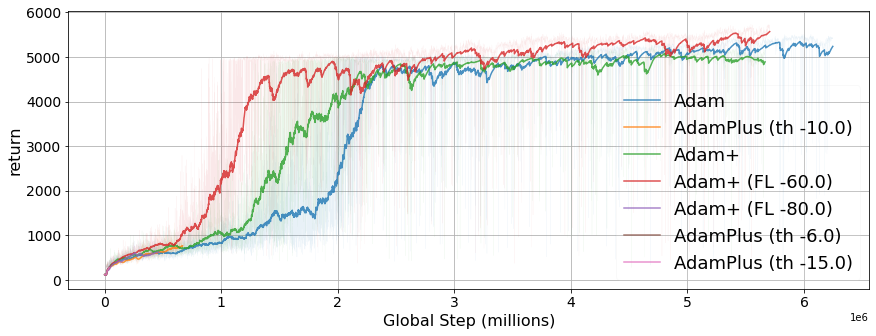

In [1921]:
# hue_order = ["Adam","AdamPlus","Adam+", "Adam2","Adam5", "Lion", "AMSGrad", "AdaBeliefW", "Adopt", "AdaBelief"]
hue_order = [
    "Adam",
    "AdamPlus (th -10.0)",
    "Adam+",
    "Adam+ (FL -60.0)",
    "Adam+ (FL -80.0)" ,
    "AdamPlus (th -6.0)",
    "AdamPlus (th -15.0)",
]
seedstr = 'env1-official'

# df_tmp = df
df_tmp = agg_df
# df_tmp= df_tmp[df_tmp["beta2"]=="0.999"]
# df_tmp= df_tmp[df_tmp["global_step"]<=700000]
# df_tmp= df[df["env"]=="lander"]
# for item in ["avg_return", "lr"]: 
for item in ["return"]: 
    fname = '../../fig/AdamPlus_{}_{}_{}_{}_{}_{}.pdf'.format(games[0], seedstr, lrs[0], dbs[0], tau, item)
    # fname = '../../fig/AdamPlus_{}_seeds_32-36_{}.pdf'.format(games[0], item)
    fig, ax = plt.subplots(1, 1, sharey=False, figsize=(12, 4.5))
    
    # Add EMA (exponential moving average) of `item` column to df_tmp
    alpha = 0.02  # smoothing factor, tune this to adjust the amount of smoothing
    ema_col = f"{item}_ema"
    
    df_tmp[ema_col] = (
        df_tmp
        .groupby(["optimizer", "beta2"])[item]
        .transform(lambda x: x.ewm(alpha=alpha).mean())
    )
    
    sns.lineplot(
        data=df_tmp, 
        x="global_step", 
        # x="time", 
        y=item, 
        hue="optimizer",
        hue_order=hue_order,
#         style="noise_injection",
#         style_order=[-120, -60.0],
        # style="beta2",
        # style_order=["0.999","0.5","0.9","0.901", "0.902", "0.903"],
        # style_order=["0.999", ], # "0.501", 
        palette="tab10", 
        errorbar=None,
    #     markers=["o", "p", "*"],
        # markersize=14,
    #     dashes=False,
    #     linestyle="dotted",
        ax=ax,
        linewidth=0.2,
        alpha=0.1,
        legend=False,  # avoid duplicate legend entries
    )
    
    # 2. Smoothed EMA curve (thicker and more prominent)
    sns.lineplot(
        data=df_tmp,
        x="global_step",
#         y=item, 
        y=ema_col,
        hue="optimizer",
        hue_order=hue_order,
#         style="noise_injection",
#         style_order=[-120, -60.0],
        # style="beta2",
        # style_order=["0.999"],
        palette="tab10",
        errorbar=None,
        ax=ax,
        linewidth=1.5,
        alpha=0.8,
        # legend=False,  # avoid duplicate legend entries
    )    
    
    
    L = ax.legend(
        fontsize=18,
        framealpha=0.1,
        ncol=1,
        # loc='upper right',
    #     loc='lower right',
    )

#     if item in ["lr"]:
#         plt.yscale("log")
#     ax.set_ylim([-5, 510])
    # ax.get_legend().remove()
    # ax.set_ylim([-1000, 1])
#     ax.set_xlim([-20000, 1020000])
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlabel('Global Step (millions)', fontsize=fontsize)
    ax.set_ylabel(item, fontsize=fontsize)

    
    fname = fname.replace('.0','_0')
    print(fname)
    # fig.set_size_inches(5.5, 4.5)
    plt.tight_layout(pad=0.1)
    fig.savefig(fname,
                dpi=300,  # facecolor='w', edgecolor='w',
                orientation='portrait',
                format='pdf')


In [1922]:
outdir="./output/"
csvfiles = os.listdir(outdir)
df = pd.DataFrame([])
agents = ["SAC"]
games = ["Walker2d-v5"]
lrs = ["3.0e-04"]
# lrs = ["1.0e-04"]
# seeds = ["30", "31", "32", "33", "34", "35", "36", "37"]
# seeds = ["31", "32", "33", "34", "35", "36", "37"]
# seeds = [str(s) for s in range(20,26)]
seeds = [str(s) for s in range(1,10)]

# seeds = ["34", "35", "36"]
# seeds = ["30"]
# betas = ["0.9", "0.5", "0.999"]
betas = ["0.999"]
explores = ["0.1"]
end_es = ["0.2"]
dbs = ["0.0"]
# betas = ["0.999"]
# game="lander"
# game="pong"
# game="breakout"
# game="spaceinvaders"
for csvfile in csvfiles:
    if ".csv" not in csvfile:
        continue
    cfgs = csvfile[0:-4].split("_")
    env, agent, optimizer, learning_rate, beta2, seed = cfgs[0], cfgs[1], cfgs[2], cfgs[3], cfgs[4], cfgs[5] 
    num_envs,policy_lr, db = cfgs[8],cfgs[7], cfgs[9]
    batch = cfgs[6]
    tau = cfgs[-1]
    if batch not in ["256"]:
        continue
    if env not in games:
        continue
    # print(csvfile[0:-4])
    if tau not in end_es:
        continue
    if agent not in agents:
        continue
    if policy_lr not in ["0.0003"]:
        continue
    if learning_rate not in lrs:
        continue
    if num_envs not in ["1"]:
        continue
    if beta2 not in betas:
        continue
    if seed[4:] not in seeds:
        continue
    try:
        df_tmp = pd.read_csv(os.path.join(outdir, csvfile), index_col=None)
    except:
        continue
    df_tmp["env"] = cfgs[0]
    df_tmp["agent"] = cfgs[1]
#     if optimizer=="Adam+" and db!="-60.0":
#         df_tmp["optimizer"] = "Adam+ (no NI)"
    if optimizer=="Adam+" and db!="-120.0":
        df_tmp["optimizer"] = "Adam+ (FL {})".format(db)
    elif optimizer=="AdamPlus" and db!="-120.0":
        df_tmp["optimizer"] = "AdamPlus (th {})".format(db)
    else:
        df_tmp["optimizer"] = cfgs[2]
    df_tmp["q_lr"]=df_tmp["lr"]  
    df_tmp["beta2"]=beta2
    df_tmp["seed"]= seed[4:]
    df_tmp["noise_injection"] = float(db)
    df_tmp["policy_lr"] = policy_lr #.str.strip("[]").astype(float)
    df_tmp["return"] = df_tmp["return"] #.str.strip("[]").astype(float)
    df_tmp["time"] = df_tmp["runtime"].cumsum(axis=0)
    df = pd.concat([df, df_tmp], ignore_index=False)
    print(csvfile[0:-4])

# df = pd.concat([df, df_saved], ignore_index=False)
df = df.reset_index(drop=True)
# df

Walker2d-v5_SAC_Adam_3.0e-04_0.999_seed1_256_0.0003_1_-120.0_0.99_0.2
Walker2d-v5_SAC_Adam52_3.0e-04_0.999_seed1_256_0.0003_1_-60.0_0.99_0.2
Walker2d-v5_SAC_Adam+_3.0e-04_0.999_seed1_256_0.0003_1_-80.0_0.99_0.2
Walker2d-v5_SAC_Adam+_3.0e-04_0.999_seed1_256_0.0003_1_-60.0_0.99_0.2
Walker2d-v5_SAC_AdamPlus_3.0e-04_0.999_seed1_256_0.0003_1_-6.0_0.99_0.2
Walker2d-v5_SAC_AdamPlus_3.0e-04_0.999_seed1_256_0.0003_1_-15.0_0.99_0.2
Walker2d-v5_SAC_Adam+0_3.0e-04_0.999_seed1_256_0.0003_1_-60.0_0.99_0.2
Walker2d-v5_SAC_Adam+_3.0e-04_0.999_seed1_256_0.0003_1_-120.0_0.99_0.2
Walker2d-v5_SAC_AdamPlus_3.0e-04_0.999_seed1_256_0.0003_1_-10.0_0.99_0.2


../../fig/AdamPlus_Walker2d-v5_env1-official_3_0e-04_0_0_0_05_return.pdf


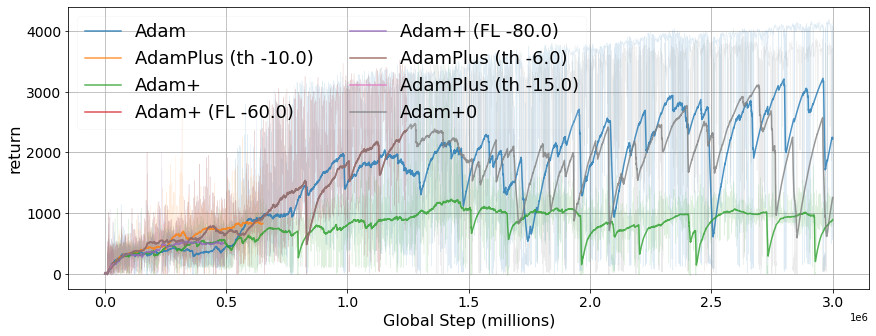

In [1924]:
# hue_order = ["Adam","AdamPlus","Adam+", "Adam2","Adam5", "Lion", "AMSGrad", "AdaBeliefW", "Adopt", "AdaBelief"]
hue_order = [
    "Adam",
    "AdamPlus (th -10.0)",
    "Adam+",
    "Adam+ (FL -60.0)",
    "Adam+ (FL -80.0)" ,
    "AdamPlus (th -6.0)",
    "AdamPlus (th -15.0)",
    "Adam+0",
]
seedstr = 'env1-official'

# df_tmp = df
df_tmp = df
# df_tmp= df_tmp[df_tmp["beta2"]=="0.999"]
# df_tmp= df_tmp[df_tmp["global_step"]<=30000]
# df_tmp= df[df["env"]=="lander"]
# for item in ["avg_return", "lr"]: 
for item in ["return"]: 
    fname = '../../fig/AdamPlus_{}_{}_{}_{}_{}_{}.pdf'.format(games[0], seedstr, lrs[0], dbs[0], tau, item)
    # fname = '../../fig/AdamPlus_{}_seeds_32-36_{}.pdf'.format(games[0], item)
    fig, ax = plt.subplots(1, 1, sharey=False, figsize=(12, 4.5))
    
    # Add EMA (exponential moving average) of `item` column to df_tmp
    alpha = 0.01  # smoothing factor, tune this to adjust the amount of smoothing
    ema_col = f"{item}_ema"
    
    df_tmp[ema_col] = (
        df_tmp
        .groupby(["optimizer", "beta2"])[item]
        .transform(lambda x: x.ewm(alpha=alpha).mean())
    )
    
    sns.lineplot(
        data=df_tmp, 
        x="global_step", 
        # x="time", 
        y=item, 
        hue="optimizer",
        hue_order=hue_order,
#         style="noise_injection",
#         style_order=[-120, -60.0],
        # style="beta2",
        # style_order=["0.999","0.5","0.9","0.901", "0.902", "0.903"],
        # style_order=["0.999", ], # "0.501", 
        palette="tab10", 
        errorbar=None,
    #     markers=["o", "p", "*"],
        # markersize=14,
    #     dashes=False,
    #     linestyle="dotted",
        ax=ax,
        linewidth=0.4,
        alpha=0.15,
        legend=False,  # avoid duplicate legend entries
    )
    
    # 2. Smoothed EMA curve (thicker and more prominent)
    sns.lineplot(
        data=df_tmp,
        x="global_step",
#         y=item, 
        y=ema_col,
        hue="optimizer",
        hue_order=hue_order,
#         style="noise_injection",
#         style_order=[-120, -60.0],
        # style="beta2",
        # style_order=["0.999"],
        palette="tab10",
        errorbar=None,
        ax=ax,
        linewidth=1.5,
        alpha=0.8,
        # legend=False,  # avoid duplicate legend entries
    )    
    
    
    L = ax.legend(
        fontsize=18,
        framealpha=0.1,
        ncol=2,
        # loc='upper right',
    #     loc='lower right',
    )

#     if item in ["lr"]:
#         plt.yscale("log")
#     ax.set_ylim([-5, 510])
    # ax.get_legend().remove()
#     ax.set_ylim([None, 1000])
#     ax.set_xlim([None, 100000])
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlabel('Global Step (millions)', fontsize=fontsize)
    ax.set_ylabel(item, fontsize=fontsize)

    
    fname = fname.replace('.0','_0')
    print(fname)
    # fig.set_size_inches(5.5, 4.5)
    plt.tight_layout(pad=0.1)
    fig.savefig(fname,
                dpi=300,  # facecolor='w', edgecolor='w',
                orientation='portrait',
                format='pdf')
